In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pyhf
import pyhf.readxml
from ipywidgets import interact, fixed

# Binned HEP Statistical Analysis in Python

## HistFactory

HistFactory is a popular framework to analyze binned event data and commonly used in High Energy Physics. At its core it is a template for building a statistical model from individual binned distribution ('Histograms') and variations on them ('Systematics') that represent auxiliary measurements (for example an energy scale of the detector which affects the shape of a distribution)

## pyhf

`pyhf` is a work-in-progress standalone implementation of the HistFactory p.d.f. template and an implementation of the test statistics and asymptotic formulae described in the paper by Cowan, Cranmer, Gross, Vitells: *Asymptotic formulae for likelihood-based tests of new physics* [[arXiv:1007.1727](https://arxiv.org/abs/1007.1727)].

Models can be defined using JSON specification, but existing models based on the XML + ROOT file scheme are readable as well.

## The Demo

The input data for the statistical analysis was built generated using the containerized workflow engine [yadage](https://github.com/scikit-hep/yadage) (see demo from KubeCon 2018 [[youtube](https://github.com/scikit-hep/yadage)]). Similarly to Binder this utilizes modern container technology for reproducible science. Below you see the execution graph leading up to the model input data at the bottom.


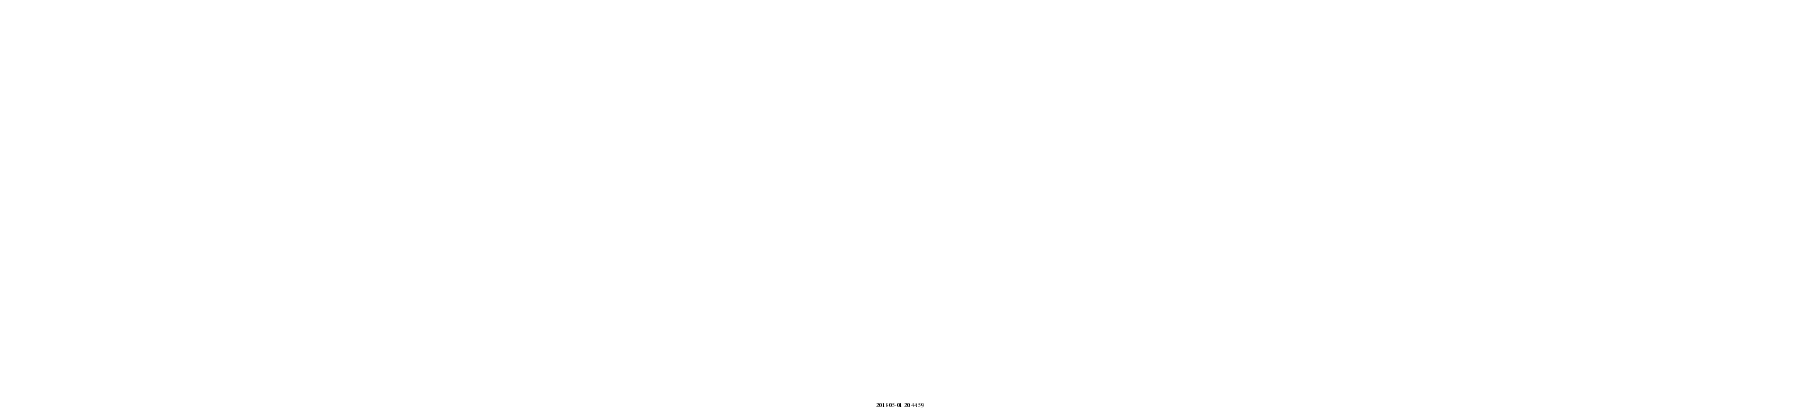

In [3]:
import base64
from IPython.core.display import display, HTML
anim = base64.b64encode(open('workflow.gif','rb').read()).decode('ascii')
HTML('<img src="data:image/gif;base64,{}">'.format(anim))

## Read in the Model from XML and ROOT

The ROOT files are read using scikit-hep's [uproot](https://github.com/scikit-hep/uproot) module.

In [4]:
spec = pyhf.readxml.parse('meas.xml',os.getcwd())
workspace = pyhf.Workspace(spec)

From the `meas.xml` spec, we construct a probability density function (p.d.f). As the model includes systematics, it will be a simultaneous joint p.d.f. of the main model (poisson) and constraint model. The latter is defined by the implied "auxiliary measurements".

In [5]:
pdf = workspace.model(measurement_name='meas')
data = workspace.data(pdf)
# what is the measurement?
workspace.get_measurement(measurement_name='meas')

{'name': 'meas',
 'config': {'poi': 'SigXsecOverSM',
  'parameters': [{'name': 'lumi',
    'auxdata': [1.0],
    'bounds': [[0.5, 1.5]],
    'inits': [1.0],
    'sigmas': [0.1]},
   {'name': 'SigXsecOverSM',
    'bounds': [[0.0, 3.0]],
    'inits': [1.0],
    'fixed': False}]}}

The p.d.f is build from one data-drived "qcd" (or multijet) estimate and two Monte Carlo-based background samples and is parametrized by five parameters: One parameter of interest `SigXsecOverSM` and four *nuisance parameters* that affect the shape of the two Monte Carlo background estimates (both weight-only and shape systematics)

In [6]:
print('Samples:\n {}'.format(workspace.samples))
print('Parameters:\n {}'.format(workspace.parameters))

Samples:
 ['mc1', 'mc2', 'qcd', 'signal']
Parameters:
 ['SigXsecOverSM', 'lumi', 'mc1_shape_conv', 'mc1_weight_var1', 'mc2_shape_conv', 'mc2_weight_var1']


In [7]:
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}
all_par_settings = {
    n[0]: tuple(m)
    for n, m in zip(
        sorted(reversed(list(par_name_dict.items())), key=lambda x: x[1]),
        pdf.config.suggested_bounds(),
    )
}
default_par_settings = {n[0]: sum(tuple(m)) / 2.0 for n, m in all_par_settings.items()}


def get_mc_counts(pars):
    deltas, factors = pdf._modifications(pars)
    allsum = pyhf.tensorlib.concatenate(
        deltas + [pyhf.tensorlib.astensor(pdf.nominal_rates)]
    )
    nom_plus_delta = pyhf.tensorlib.sum(allsum, axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(
        nom_plus_delta, (1,) + pyhf.tensorlib.shape(nom_plus_delta)
    )
    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    return pyhf.tensorlib.product(allfac, axis=0)


animate_plot_pieces = None


def init_plot(fig, ax, par_settings):
    global animate_plot_pieces

    nbins = sum(list(pdf.config.channel_nbins.values()))
    x = np.arange(nbins)
    data = np.zeros(nbins)
    items = []
    for i in [3, 2, 1, 0]:
        items.append(ax.bar(x, data, 1, alpha=1.0))
    animate_plot_pieces = (
        items,
        ax.scatter(x, workspace.data(pdf, with_aux=False), c="k", alpha=1.0, zorder=99),
    )


def animate(ax=None, fig=None, **par_settings):
    global animate_plot_pieces
    items, obs = animate_plot_pieces
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    rectangle_collection = zip(*map(lambda x: x.patches, items))

    for rectangles, binvalues in zip(rectangle_collection, mc_counts[:, 0].T):
        offset = 0
        for sample_index in [3, 2, 1, 0]:
            rect = rectangles[sample_index]
            binvalue = binvalues[sample_index]
            rect.set_y(offset)
            rect.set_height(binvalue)
            offset += rect.get_height()

    fig.canvas.draw()


def plot(ax=None, order=[3, 2, 1, 0], **par_settings):
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    bottom = None
    # nb: bar_data[0] because evaluating only one parset
    for i, sample_index in enumerate(order):
        data = mc_counts[sample_index][0]
        x = np.arange(len(data))
        ax.bar(x, data, 1, bottom=bottom, alpha=1.0)
        bottom = data if i == 0 else bottom + data
    ax.scatter(x, workspace.data(pdf, with_aux=False), c="k", alpha=1.0, zorder=99)

## Interactive Exploration of a HistFactory Model

One advantage of a pure-python implementation of Histfactory is the ability to explore the pdf interactively within the setting of a notebook. Try moving the sliders and oberserve the effect on the samples. For example changing the parameter of interest `SigXsecOverSM` (or µ) controls the overall normalization of the (BSM) signal sample (µ=0 for background-only and µ=1 for the nominal signal-plus-background hypothesis)

<IPython.core.display.Javascript object>


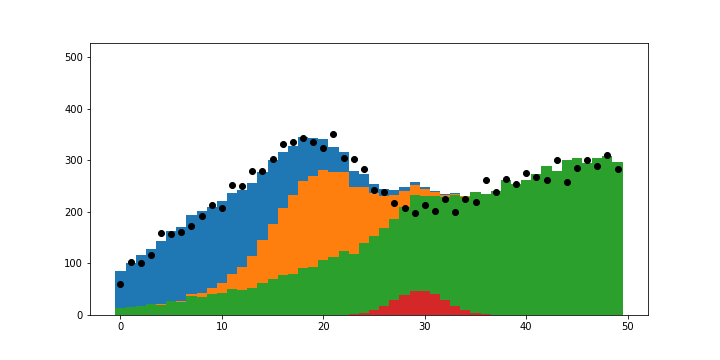

interactive(children=(FloatSlider(value=1.0, description='lumi', max=1.5, min=0.5), FloatSlider(value=1.5, des…

In [8]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.set_ylim(0, 1.5 * np.max(workspace.data(pdf, with_aux=False)))

init_plot(fig, ax, default_par_settings)
interact(animate, fig=fixed(fig), ax=fixed(ax), **all_par_settings);

In [9]:
nominal = pdf.config.suggested_init()
background_only = pdf.config.suggested_init()
background_only[pdf.config.poi_index] = 0.0
best_fit = pyhf.infer.mle.fit(data, pdf)

/Users/jovyan/pyhf/src/pyhf/tensor/numpy_backend.py:253: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


## Fitting

We can now fit the statistical model to the observed data. The best fit of the signal strength is close to the background-only hypothesis.

<IPython.core.display.Javascript object>


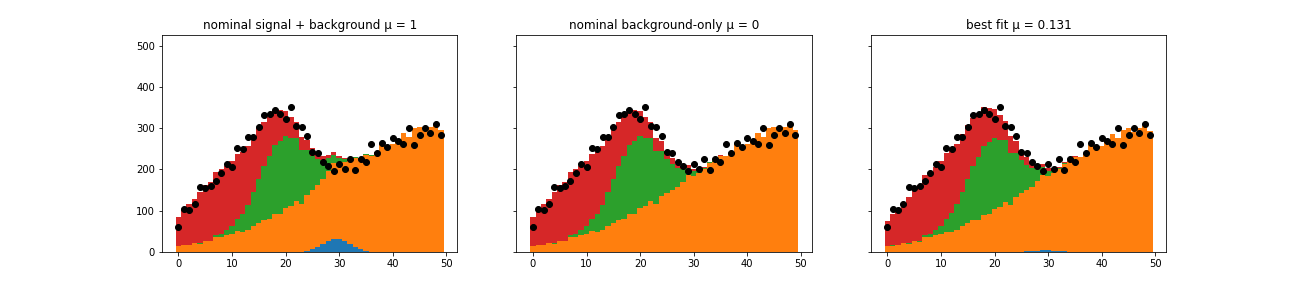

In [10]:
f,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, sharex=True)
f.set_size_inches(18,4)
ax1.set_ylim(0,1.5*np.max(workspace.data(pdf, with_aux=False)))
ax1.set_title(u'nominal signal + background µ = 1')
plot(ax = ax1, **{k: nominal[v] for k,v in par_name_dict.items()})

ax2.set_title(u'nominal background-only µ = 0')
plot(ax = ax2, **{k: background_only[v] for k,v in par_name_dict.items()})

ax3.set_title(u'best fit µ = {:.3g}'.format(best_fit[pdf.config.poi_index]))
plot(ax = ax3, **{k: best_fit[v] for k,v in par_name_dict.items()});

## Interval Estimation (Computing Upper Limits on µ)

A common task in the statistical evaluation of High Energy Physics data analyses is the estimation of confidence intervals of parameters of interest. The general strategy is to perform a series of hypothesis tests and then *invert* the tests in order to obtain an interval with the correct coverage properties.

A common figure of merit is a modified p-value, CLs. Here we compute an upper limit based on a series of CLs tests.

In [11]:
def invert_interval(test_mus, hypo_tests, test_size=0.05):
    cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
    cls_exp = [
        np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)
    ]
    crossing_test_stats = {"exp": [], "obs": None}
    for cls_exp_sigma in cls_exp:
        crossing_test_stats["exp"].append(
            np.interp(
                test_size, list(reversed(cls_exp_sigma)), list(reversed(test_mus))
            )
        )
    crossing_test_stats["obs"] = np.interp(
        test_size, list(reversed(cls_obs)), list(reversed(test_mus))
    )
    return crossing_test_stats

In [12]:
mu_tests = np.linspace(0, 1, 16)
hypo_tests = [
    pyhf.infer.hypotest(
        mu,
        data,
        pdf,
        pdf.config.suggested_init(),
        pdf.config.suggested_bounds(),
        return_expected_set=True,
    )
    for mu in mu_tests
]

<IPython.core.display.Javascript object>


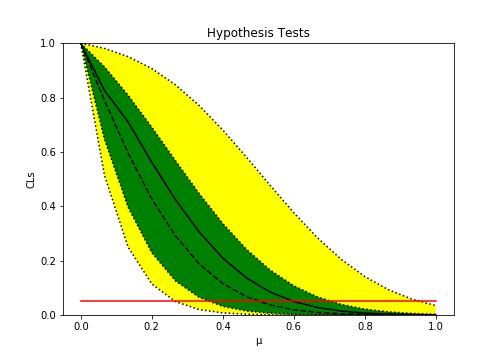

In [13]:
import pyhf.contrib.viz.brazil

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(7, 5)

ax1.set_title(u"Hypothesis Tests")
ax1.set_ylabel(u"CLs")
ax1.set_xlabel(u"µ")

pyhf.contrib.viz.brazil.plot_results(ax1, mu_tests, hypo_tests);

In [14]:
results = invert_interval(mu_tests, hypo_tests)

print('Observed Limit: {:.2f}'.format(results['obs']))
print('-----')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.3f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results['exp'][i]))

Observed Limit: 0.60
-----
Expected Limit(-2 σ): 0.266
Expected Limit(-1 σ): 0.363
Expected Limit: 0.505
Expected Limit(1 σ): 0.707
Expected Limit(2 σ): 0.956
